# Récupération des librairies

In [1]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération des librairies
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency

from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso, LassoCV, lasso_path, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Récupération et amélioration du jeu de données

## Préparation des données

In [3]:
# chargement des données en local
# from google.colab import files
# uploaded = files.upload()

In [4]:
# récupération du jeu de données
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
# récupération du jeu de données sur Gdrive
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datascientest/Meteo/weatherAUS.csv')
# df.head()

In [6]:
# taille du DataFrame initial
obs_init = df.shape[0]
var_init = df.shape[1]

print("Taille du DataFrame initial:\n")
print("Nombre d'observations : {} \n Nombre de variables : {}".format(df.shape[0], df.shape[1]))

Taille du DataFrame initial:

Nombre d'observations : 145460 
 Nombre de variables : 23


In [7]:
# suppression des doublons
df.drop_duplicates(inplace=True)

In [8]:
# détection des valeurs manquantes sur tout le dataframe
print("Pourcentage de valeurs manquantes sur tout le dataframe: \n")
df.isna().sum().sort_values(ascending=False).apply(lambda val : val/df.shape[0] * 100)

Pourcentage de valeurs manquantes sur tout le dataframe: 



Sunshine         48.009762
Evaporation      43.166506
Cloud3pm         40.807095
Cloud9am         38.421559
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
Temp9am           1.214767
WindSpeed9am      1.214767
MinTemp           1.020899
MaxTemp           0.866905
Location          0.000000
Date              0.000000
dtype: float64

 - Les variables 'Sunshine', 'Evaporation', 'Cloud3pm' et 'Cloud9am' présentent la plus forte proportion de valeurs manquantes (entre 35% et 50%).
 - Les variables "Date" et "Location" n'ont pas de valeurs manquantes.
 - Les autres variables présentent moins de 10% de valeurs manquantes.

In [9]:
# suppression des valeurs manquantes pour "RainToday" et "RainTomorrow" qui ne contiennent que deux modalités.
df.dropna(subset=['RainTomorrow', 'RainToday'], inplace=True)

In [10]:
# encodage des variables qualitatives binaires
df['RainToday'].replace({'No':0, 'Yes':1}, inplace = True)
df['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace = True)

df['RainToday'] = df['RainToday'].astype('int64')
df['RainTomorrow'] = df['RainTomorrow'].astype('int64')

In [11]:
# remplacement des NANs pour les variables présentant la plus forte proportion de valeurs manquantes
# temps de calcul : ~ 1 h 30 min
X = df[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']]
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model = make_pipeline(KNNImputer(), SGDClassifier())

params = {'knnimputer__n_neighbors' : [1,2,3,4]}

grid = GridSearchCV(model, param_grid=params, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('knnimputer', KNNImputer()),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'knnimputer__n_neighbors': [1, 2, 3, 4]})

In [12]:
grid.best_params_

{'knnimputer__n_neighbors': 4}

In [13]:
best_param = 2

In [14]:
# temps de calcul : ~ 20 min.
imputer = KNNImputer(n_neighbors = best_param)
df[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']] = imputer.fit_transform(df[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']])

In [15]:
# détection des valeurs manquantes sur tout le dataframe
print("Pourcentage de valeurs manquantes sur tout le dataframe: \n")
df.isna().sum().sort_values(ascending=False).apply(lambda val : val/df.shape[0]*100)

Pourcentage de valeurs manquantes sur tout le dataframe: 



Pressure3pm      9.780022
Pressure9am      9.761555
WindDir9am       6.861429
WindGustDir      6.508413
WindGustSpeed    6.467216
WindDir3pm       2.606775
Humidity3pm      2.486735
Temp3pm          1.863808
WindSpeed3pm     1.797751
Humidity9am      1.077514
WindSpeed9am     0.749359
Temp9am          0.465952
MinTemp          0.332417
MaxTemp          0.218060
RainToday        0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Date             0.000000
Location         0.000000
Sunshine         0.000000
Evaporation      0.000000
Rainfall         0.000000
RainTomorrow     0.000000
dtype: float64

In [16]:
# remplacement des NANs pour les variables présentant des valeurs manquantes
num_vars_with_nans = ['Pressure3pm','Pressure9am','WindGustSpeed','Humidity3pm','Temp3pm','WindSpeed3pm','Humidity9am','WindSpeed9am','Temp9am','MinTemp','MaxTemp']

index_date = pd.to_datetime(df['Date'])
df = df.set_index(index_date)

df_date = df.set_index(index_date)[num_vars_with_nans]
df_date.head()

,Pressure3pm,Pressure9am,WindGustSpeed,Humidity3pm,Temp3pm,WindSpeed3pm,Humidity9am,WindSpeed9am,Temp9am,MinTemp,MaxTemp
Date,,,,,,,,,,,
2008-12-01,1007.1,1007.7,44.0,22.0,21.8,24.0,71.0,20.0,16.9,13.4,22.9
2008-12-02,1007.8,1010.6,44.0,25.0,24.3,22.0,44.0,4.0,17.2,7.4,25.1
2008-12-03,1008.7,1007.6,46.0,30.0,23.2,26.0,38.0,19.0,21.0,12.9,25.7
2008-12-04,1012.8,1017.6,24.0,16.0,26.5,9.0,45.0,11.0,18.1,9.2,28.0
2008-12-05,1006.0,1010.8,41.0,33.0,29.7,20.0,82.0,7.0,17.8,17.5,32.3


In [17]:
# remplacement des NANs pour les variables présentant des valeurs manquantes
df_date = df_date.interpolate(method="time")

In [18]:
# remplacement des NANs pour les variables présentant des valeurs manquantes
df[num_vars_with_nans] = df_date[num_vars_with_nans]

In [19]:
df.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir      9163
WindGustSpeed       0
WindDir9am       9660
WindDir3pm       3670
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
dtype: int64

In [20]:
# remplacement des valeurs manquantes en utilisant le mode
for feat in ['WindGustDir', 'WindDir9am', 'WindDir3pm'] :
    df[feat].fillna(df[feat].mode()[0], inplace=True)

In [21]:
# vérification finale sur le nombre de valeurs manquantes
df.isna().sum().sum()

0

In [22]:
# définition de nouvelles variables
df['Temp_Delta_MinMax'] = df['MaxTemp'] - df['MinTemp']
df['Humidity_Delta'] = df['Humidity3pm'] - df['Humidity9am']

In [23]:
# corrélations avec la variable cible
df.corr()['RainTomorrow'].sort_values(ascending=False)

RainTomorrow         1.000000
Humidity3pm          0.438034
RainToday            0.313097
Cloud3pm             0.290933
Humidity9am          0.256141
Humidity_Delta       0.253574
Cloud9am             0.244901
Rainfall             0.239032
WindGustSpeed        0.217533
WindSpeed9am         0.089186
WindSpeed3pm         0.085503
MinTemp              0.083992
Temp9am             -0.025635
Evaporation         -0.090407
MaxTemp             -0.159395
Temp3pm             -0.188807
Pressure3pm         -0.211297
Pressure9am         -0.229678
Temp_Delta_MinMax   -0.336272
Sunshine            -0.344921
Name: RainTomorrow, dtype: float64

In [24]:
# suppression des variables les moins corrélées à la variable cible (choix arbitraire : 'inférieur à 0.15 en valeur absolue')
df.drop(columns=['WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'Temp9am', 'Evaporation'], inplace=True)

In [25]:
# suppression de la date car ni l'année, le mois, la semaine ou la journée ne sont pas très corrélées avec la variable cible
df.drop(columns=['Date'], inplace=True)

In [26]:
# définition de la fonction mesurant le niveau de corrélation par le V de Cramer
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0, (stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1, r_corr - 1))

In [27]:
# table de contingence entre entre les variables 'Humidity9am' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Humidity9am'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.27673959015296234


In [28]:
# table de contingence entre les variables 'Humidity_Delta' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Humidity_Delta'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.28019656157074646


In [29]:
# suppression de la variable "Humidity9am", moins corrélée à la variable cible que "Humidity_Delta"
df.drop(columns=['Humidity9am'], inplace=True)

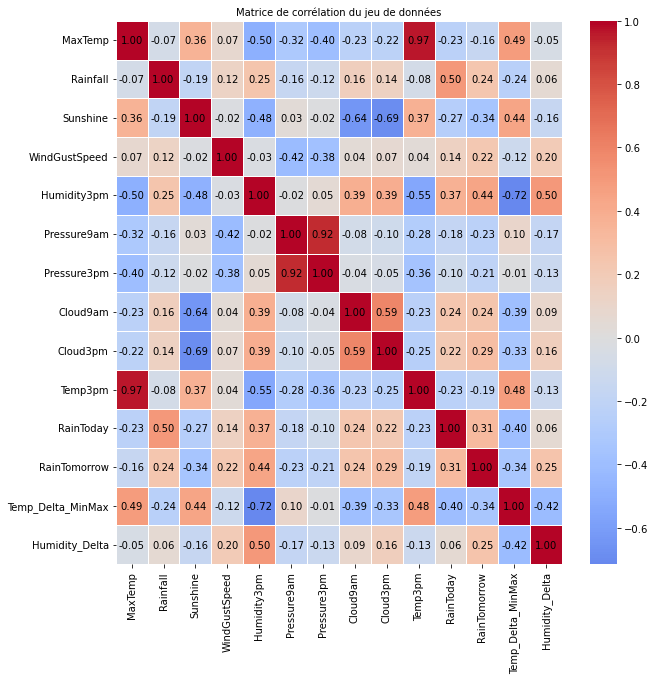

In [30]:
# création de la matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10,  
           'color':"k", 
           'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- 'Temp3pm' et 'MaxTemp' sont très fortement corrélées (+0.97)
- 'Pressure9am' et 'Pressure3pm' sont très fortement corrélées (+0.92)
- 'Humidity3pm' et 'Temp_Delta_MinMax' sont très fortement corrélées (-0.72)
- 'Sunshine' et 'Cloud3pm' sont fortement corrélées (-0.68)
- 'Sunshine' et 'Cloud9am' sont fortement corrélées (-0.62)
- 'Cloud9am' et 'Cloud3pm' sont fortement corrélées (+0.59)
- 'Humidity3pm' et 'Temp3pm' sont fortement corrélées (-0.55)

In [31]:
# table de contingence entre les variables 'Pressure9am' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Pressure9am'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.24423121889156266


In [32]:
# table de contingence entre les variables 'Pressure3pm' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Pressure3pm'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.22808735874790356


In [33]:
# suppression de la variable "Pressure3pm", moins corrélée à la variable cible que "Pressure9am"
df.drop(columns=['Pressure3pm'], inplace=True)

In [34]:
# table de contingence entre les variables 'Cloud9am' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Cloud9am'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.251471944657199


In [35]:
# table de contingence entre les variables 'Cloud3pm' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Cloud3pm'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.30240619666711077


In [36]:
# suppression de la variable "Cloud9am", moins corrélée à la variable cible que "Cloud3pm"
df.drop(columns=['Cloud9am'], inplace=True)

In [37]:
# récupération des variables quantitatives
num_features = [col for col in df.columns if df[col].dtype != 'O']
num_data = df.select_dtypes(include='number')

print("Variables quantitatives: {}".format(num_features),'\n')
print("Nombre de variables quantitatives: {}".format(len(num_features)))

Variables quantitatives: ['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Temp_Delta_MinMax', 'Humidity_Delta'] 

Nombre de variables quantitatives: 12


In [38]:
# cardinalité
for feature in num_features:
    print("Cardinalité de '{}': {}".format(feature, len(df[feature].unique())))

Cardinalité de 'MaxTemp': 503
Cardinalité de 'Rainfall': 679
Cardinalité de 'Sunshine': 376
Cardinalité de 'WindGustSpeed': 68
Cardinalité de 'Humidity3pm': 101
Cardinalité de 'Pressure9am': 545
Cardinalité de 'Cloud3pm': 19
Cardinalité de 'Temp3pm': 500
Cardinalité de 'RainToday': 2
Cardinalité de 'RainTomorrow': 2
Cardinalité de 'Temp_Delta_MinMax': 1094
Cardinalité de 'Humidity_Delta': 165


In [39]:
# suppression de la variable "RainToday" qui ne contient que deux modalités et se comporte donc plutôt comme une variable qualitative 
# df.drop(columns=['RainToday'], inplace=True)

In [40]:
# mise à jour de la liste des colonnes du DataFrame
# num_features = [col for col in df.columns if df[col].dtype != 'O']

In [41]:
# récupération des variables qualitatives
cat_features = [col for col in df.columns if df[col].dtype == 'O']
cat_data = df.select_dtypes(include = 'O')

print("Variables qualitatives: ", cat_features,'\n')
print("Nombre de variables qualitatives: ", len(cat_features))

Variables qualitatives:  ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] 

Nombre de variables qualitatives:  4


In [42]:
# cardinalité
for feature in cat_features:
    print("Cardinalité de '{}': {}".format(feature, len(df[feature].unique())))

Cardinalité de 'Location': 49
Cardinalité de 'WindGustDir': 16
Cardinalité de 'WindDir9am': 16
Cardinalité de 'WindDir3pm': 16


In [43]:
# suppression des variables quantitatives "WindGustDir", "WindDir9am" et "WindDir3pm" qui présentent une cardinalité trop forte
df.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace=True)

In [44]:
# mise à jour de la liste des colonnes du DataFrame
cat_features = [col for col in df.columns if df[col].dtype == 'O']

In [45]:
# transformation des variables qualitatives en variables numériques (Olivier)
# for column in cat_features:
#    l = df[column].value_counts().index.tolist() 
#    mapping = {x:y for x,y in zip(l, range(len(l)))}
#    df[column] = df[column].map(mapping) 

In [46]:
# dichotomisation (one hot encoding)
# onehot_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# def one_hot_encode(df, cat, prefix):
#     for col, pref in zip(cat, prefix):
#         dummy = pd.get_dummies(df[col], prefix=pref)
#         df = pd.concat([df, dummy], axis=1)
#         df = df.drop(col, axis=1)
#     return df

# df = one_hot_encode(df, onehot_features, ['wgd', 'wd9', 'wd3'])

In [47]:
# calcul des valeurs délimitant les outliers et remplacement des outliers par la valeur des limites 
for feature in ['MaxTemp','WindGustSpeed','Humidity3pm','Pressure9am','Rainfall','Temp3pm','Temp_Delta_MinMax','Humidity_Delta']:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    df.loc[df[feature] < lower_limit, feature] = lower_limit
    df.loc[df[feature] > upper_limit, feature] = upper_limit

In [48]:
# remplacement des valeurs manquantes en utilisant la moyenne
# for feat in num_features :
#     df[feat].fillna(df[feat].mean(), inplace=True)

In [49]:
# Vérification des valeurs manquantes sur tout le DataFrame
# df.isnull().sum().sum()

In [50]:
# taille du DataFrame réduit
print("Taille du DataFrame réduit:\n")

print("Nombre d'observations initial: {} \n Nombre de variables initial: {} \n".format(obs_init, var_init))
print("Nombre d'observations actuel: {} \n Nombre de variables actuel: {} \n".format(df.shape[0], df.shape[1]))

print("{} % des observations retirées".format(round(100*(obs_init-df.shape[0])/obs_init,1)))
print("{} % des variables retirées".format(round(100*(var_init-df.shape[1])/var_init,1)))

Taille du DataFrame réduit:

Nombre d'observations initial: 145460 
 Nombre de variables initial: 23 

Nombre d'observations actuel: 140787 
 Nombre de variables actuel: 13 

3.2 % des observations retirées
43.5 % des variables retirées


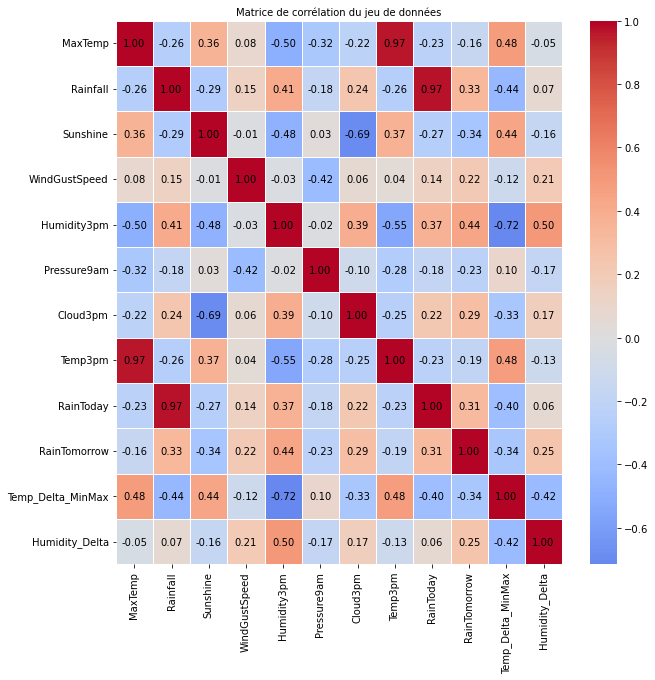

In [51]:
# matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10, 'color':"k", 'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- 'Temp3pm' et 'MaxTemp' sont très fortement corrélées (+0.97)
- 'RainToday' et 'Rainfall' sont très fortement corrélées (+0.97)
- 'Humidity3pm' et 'Temp_Delta_MinMax' sont très fortement corrélées (-0.72)
- 'Sunshine' et 'Cloud3pm' sont fortement corrélées (-0.68)
- 'Humidity3pm' et 'Temp3pm' sont fortement corrélées (-0.55)

In [52]:
df.to_csv('weatherAUS_preprocessed_before_city_clust.csv')

## Classification des villes en fonction du climat

In [53]:
df = pd.read_csv("weatherAUS_preprocessed_before_city_clust.csv")

In [54]:
df.drop(columns=['Date'], inplace=True)

In [55]:
# chargement des coordonnées géographiques en local
#uploaded = files.upload()
aus_town_gps = pd.read_csv("aus_town_gps.csv",sep=",")

In [56]:
# chargement du climat en local
#uploaded = files.upload()
climatsaus = pd.read_csv("climatsAUS_v2.csv",sep=";")

In [57]:
# Pour simplifier, on regroupe les climats en 4 catégories : chaud_humide, tempéré_froid, sec et méditerranéen. On pourra ainsi faire des visualisations plus facilement.
climats_type = {'Am':'chaud_humide',
                'Aw':'chaud_humide',
                'Cfa':'chaud_humide',
                'Cfb':'tempéré_froid', 
                'Cfc':'tempéré_froid', 
                'BSh':'sec',
                'BSk':'sec',
                'Bsk':'sec', 
                'Bwh':'sec',
                'Csa':'méditerranéen',
                'Csb':'méditerranéen'              
               }

climatsaus['Clim_type']=climatsaus['Climat_Koppen'].map(climats_type)

In [58]:
df = pd.merge(df, aus_town_gps, how='left', left_on="Location",right_on="Location")
df = pd.merge(df, climatsaus, how='left', left_on="Location",right_on="Location")

In [59]:
clim_indic = pd.get_dummies(df.Clim_type, prefix='clim')
df = df.join(clim_indic).drop('Clim_type', axis=1)

In [60]:
# suppression des colonnes
df.drop(columns=['Location','Latitude', 'Longitude', 'Climat_Koppen'], inplace=True)

In [61]:
df.to_csv('weatherAUS_Rev0.csv')

In [62]:
# taille du DataFrame réduit
print("Taille du DataFrame réduit:\n")

print("Nombre d'observations initial: {} \n Nombre de variables initial: {} \n".format(obs_init, var_init))
print("Nombre d'observations actuel: {} \n Nombre de variables actuel: {} \n".format(df.shape[0], df.shape[1]))

print("{} % des observations retirées".format(round(100*(obs_init-df.shape[0])/obs_init,1)))
print("{} % des variables retirées".format(round(100*(var_init-df.shape[1])/var_init,1)))

Taille du DataFrame réduit:

Nombre d'observations initial: 145460 
 Nombre de variables initial: 23 

Nombre d'observations actuel: 140787 
 Nombre de variables actuel: 16 

3.2 % des observations retirées
30.4 % des variables retirées


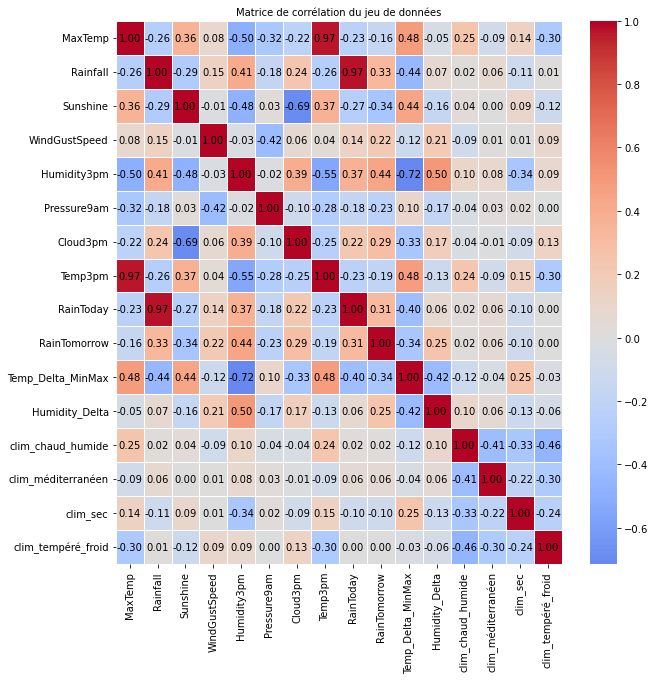

In [63]:
# matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10, 'color':"k", 'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- 'Temp3pm' et 'MaxTemp' sont très fortement corrélées (+0.97)
- 'RainToday' et 'Rainfall' sont très fortement corrélées (+0.97)
- 'Humidity3pm' et 'Temp_Delta_MinMax' sont très fortement corrélées (-0.72)
- 'Sunshine' et 'Cloud3pm' sont fortement corrélées (-0.68)
- 'Humidity3pm' et 'Temp3pm' sont fortement corrélées (-0.55)

## Sélection de variables avec SelectKBest

In [64]:
df = pd.read_csv("weatherAUS_Rev0.csv", index_col=0)
df_copy = df.copy()
# séparation des données en une matrice de données et en un vecteur cible
data = df_copy.drop(columns=['RainTomorrow'])
target = df_copy['RainTomorrow']
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=123)

In [65]:
# SelectKBest nécessite des données positives pour le chi2
X_Kbest = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns)

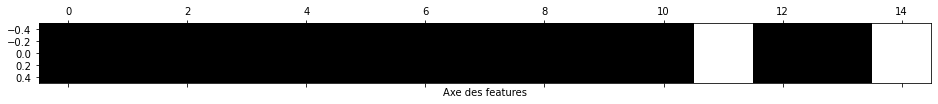

In [66]:
sel = SelectKBest(score_func = chi2, k=13)
sel.fit(X_Kbest, y_train)
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

In [67]:
select_feats = X_train.columns[mask]
X_train.columns[mask]

Index(['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm',
       'Pressure9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'Temp_Delta_MinMax',
       'Humidity_Delta', 'clim_méditerranéen', 'clim_sec'],
      dtype='object')

## Sauvegarde du jeu de données

In [68]:
df.to_csv('weatherAUS_preprocessed.csv')